**Fourteenth chapter of Hands-on Machine learning with Scikit-Learn, Keras, and Tensorflow.**

Find the book from → [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd edition)](https://homl.info/er3)

# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

perception is not trivial at all, and to understand it we must look at how our sensory module work.

# Convolutional Layers

## Implementing Convolutional Layers With Keras

In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

In [7]:
images.shape

TensorShape([2, 70, 120, 3])

In [8]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7) # padding='valid' by default
fmaps = conv_layer(images)

In [9]:
fmaps.shape

TensorShape([2, 64, 114, 32])

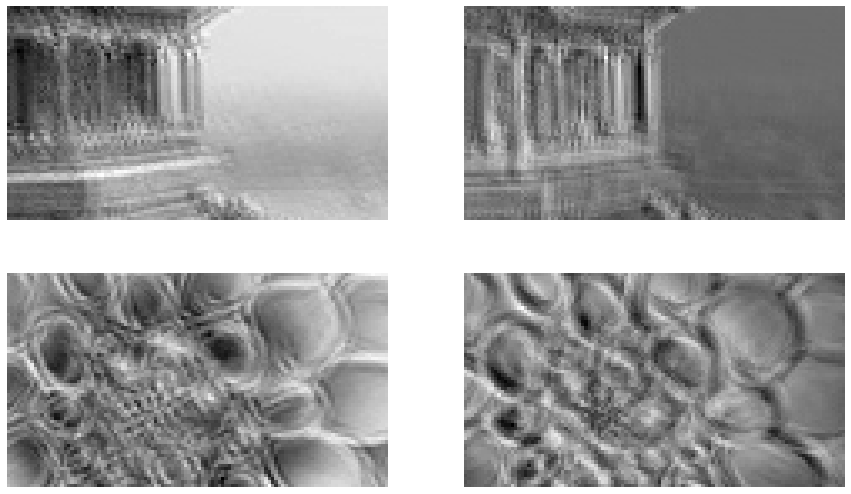

In [10]:
# displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.



Now let's use zero-padding:


In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [12]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [13]:
# shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [14]:
# this utility function can be useful to compute the size of the
# feature maps output by a convolutional layer. It also returns
# the number of ignored rows or columns if padding="valid", or the
# number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [15]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
# shows how to use the tf.nn.conv2d() operation
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter. The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

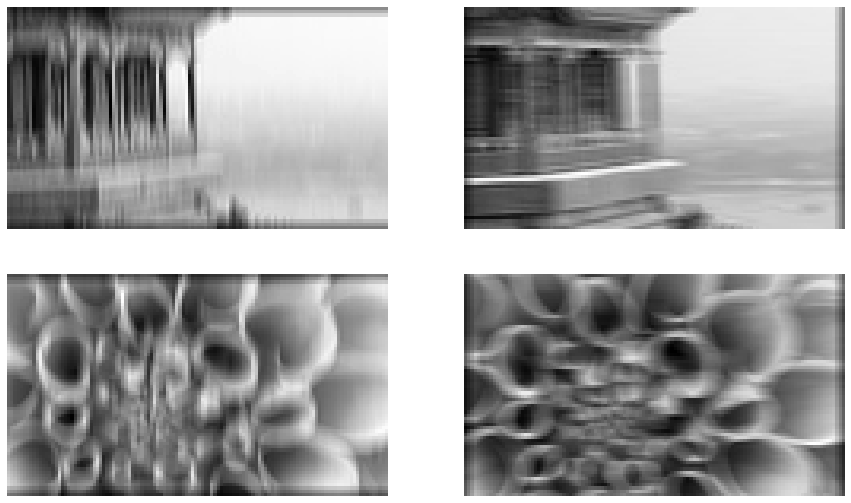

In [18]:
# shows how to manually create two filters to get images similar
# to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# Pooling Layers

## Implementing Pooling layers With Keras

**Max pooling**

In [19]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [20]:
output = max_pool(images)

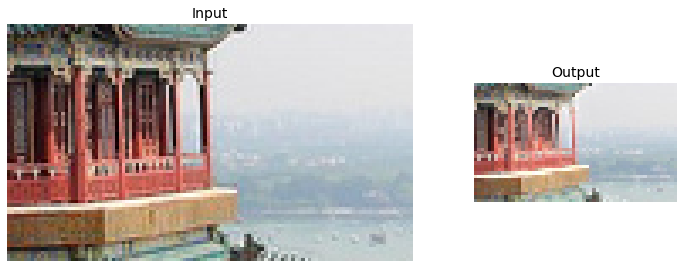

In [21]:
# This cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [22]:
# Shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

Keras does not include a depthwise max pooling layer, but it’s not too
difficult to implement a custom layer for that:

In [23]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [24]:
# Shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

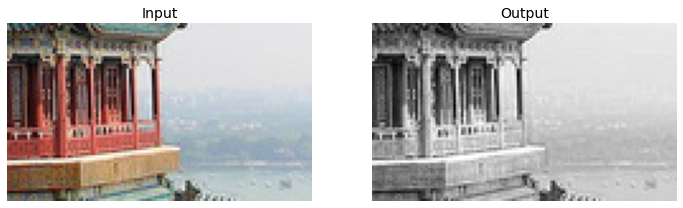

In [25]:
# computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling** 

In [26]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [27]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [28]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.2601088 , 0.10848834]], dtype=float32)>

# CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [29]:
# Loads the mnist dataset, add the channels axis to the inputs,
# scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [30]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [31]:
# Compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 27s 9ms/step - loss: 0.7348 - accuracy: 0.7400 - val_loss: 0.4019 - val_accuracy: 0.8586
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4222 - accuracy: 0.8594 - val_loss: 0.3110 - val_accuracy: 0.8914
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3530 - accuracy: 0.8815 - val_loss: 0.2843 - val_accuracy: 0.8950
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3126 - accuracy: 0.8972 - val_loss: 0.2598 - val_accuracy: 0.9010
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2802 - accuracy: 0.9045 - val_loss: 0.2675 - val_accuracy: 0.9010
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2619 - accuracy: 0.9128 - val_loss: 0.2925 - val_accuracy: 0.9010
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2460 - accuracy: 0.9163 - val_loss: 0.2737 - val_a

## LeNet-5

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

## AlexNet

It is similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a
pooling layer on top of each convolutional layer.

To reduce overfitting, the authors used two regularization techniques. First,
they applied dropout (introduced in Chapter 11) with a 50% dropout rate
during training to the outputs of layers F9 and F10. Second, they performed
data augmentation by randomly shifting the training images by various
offsets, flipping them horizontally, and changing the lighting conditions.

AlexNet also uses a competitive normalization step immediately after the
ReLU step of layers C1 and C3, called local response normalization (LRN):
the most strongly activated neurons inhibit other neurons located at the
same position in neighboring feature maps. Such competitive activation has
been observed in biological neurons. This encourages different feature maps
to specialize, pushing them apart and forcing them to explore a wider range
of features, ultimately improving generalization.

## GoogLeNet

This was made possible by subnetworks called inception modules,⁠14 which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million
instead of 60 million).

## VGGNet

VGGNet had 2 or 3 convolutional layers and a pooling layer, then
again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a
total of 16 or 19 convolutional layers, depending on the VGG variant), plus
a final dense network with 2 hidden layers and the output layer. It used
small 3 × 3 filters, but it had many of them.

## ResNet

The winning variant used an extremely deep CNN composed of 152
layers (other variants had 34, 50, and 101 layers). It confirmed the general
trend: computer vision models were getting deeper and deeper, with fewer
and fewer parameters. The key to being able to train such a deep network is
to use skip connections (also called shortcut connections): the signal
feeding into a layer is also added to the output of a layer located higher up
the stack.

When training a neural network, the goal is to make it model a target
function h(x). If you add the input x to the output of the network (i.e., you
add a skip connection), then the network will be forced to model f(x) = h(x)
– x rather than h(x). This is called residual learning.

When you initialize a regular neural network, its weights are close to zero,
so the network just outputs values close to zero. If you add a skip
connection, the resulting network just outputs a copy of its inputs; in other
words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.

Moreover, if you add many skip connections, the network can start making
progress even if several layers have not started learning yet.

## Xception

Another variant of the GoogLeNet architecture is worth noting: Xception⁠19
(which stands for Extreme Inception).

Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a depthwise
separable convolution layer (or separable convolution layer for short⁠).

These layers had been used before in some CNN architectures, but they
were not as central as in the Xception architecture. While a regular
convolutional layer uses filters that try to simultaneously capture spatial
patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose +
eyes = face), a separable convolutional layer makes the strong assumption
that spatial patterns and cross-channel patterns can be modeled separately. Thus, it is composed of two parts: the first part applies a single spatial filter to each input feature map, then the second part looks exclusively for cross-channel patterns—it is just a regular convolutional layer with 1 × 1 filters.

## SENet

The winning architecture in the ILSVRC 2017 challenge was the Squeeze-
and-Excitation Network (SENet).⁠ This architecture extends existing
architectures such as inception networks and ResNets, and boosts their
performance. The boost comes from the fact that a SENet adds a small neural network, called an SE block, to every inception module or residual unit in the original architecture.
The boost comes from the fact that a SENet adds a small neural network,
called an SE block, to every inception module or residual unit in the original
architecture. An SE block may learn that mouths, noses, and eyes usually
appear together in pictures: if you see a mouth and a nose, you shouldexpect to see eyes as well.

## ResNeXt

ResNeXt improves the residual units in ResNet. Whereas the residual
units in the best ResNet models just contain 3 convolutional layers each,
the ResNeXt residual units are composed of many parallel stacks (e.g.,
32 stacks), with 3 convolutional layers each. However, the first two
layers in each stack only use a few filters (e.g., just four), so the overall
number of parameters remains the same as in ResNet. Then the outputs
of all the stacks are added together, and the result is passed to the next
residual unit (along with the skip connection).

## DenseNet

A DenseNet is composed of several dense blocks, each made up of a
few densely connected convolutional layers. This architecture achieved
excellent accuracy while using comparatively few parameters. What
does “densely connected” mean? The output of each layer is fed as
input to every layer after it within the same block. For example, layer 4
in a block takes as input the depthwise concatenation of the outputs of
layers 1, 2, and 3 in that block. Dense blocks are separated by a few
transition layers.

## MobileNet

MobileNets are streamlined models designed to be lightweight and fast,
making them popular in mobile and web applications. They are based
on depthwise separable convolutional layers, like Xception. The authors
proposed several variants, trading a bit of accuracy for faster and
smaller models.

## CSPNet

A Cross Stage Partial Network (CSPNet) is similar to a DenseNet, but
part of each dense block’s input is concatenated directly to that block’s
output, without going through the block.

## EfficientNet

EfficientNet is arguably the most important model in this list. The
authors proposed a method to scale any CNN efficiently, by jointly
increasing the depth (number of layers), width (number of filters per
layer), and resolution (size of the input image) in a principled way. This
is called compound scaling. They used neural architecture search to find
a good architecture for a scaled-down version of ImageNet (with
smaller and fewer images), and then used compound scaling to create
larger and larger versions of this architecture. When EfficientNet
models came out, they vastly outperformed all existing models, across
all compute budgets, and they remain among the best models out there
today.

## Choosing the Right CNN architecture

You can find the full list of pre trained modules available in keras at https://keras.io/api/applications

# Implementing a ResNet-34 CNN Using Keras

In [32]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)


class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

As explained In the book, the first 3 RUs have 64 filters, then
the next 4 RUs have 128 filters, and so on. At each iteration, we must set
the stride to 1 when the number of filters is the same as in the previous RU,
or else we set it to 2; then we add the ResidualUnit, and finally we update
prev_filters.

In [33]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

# Using Pretrained Models from Keras

In [34]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 1s 0us/step


In [35]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [36]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [37]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 1s/step


(2, 1000)

In [38]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


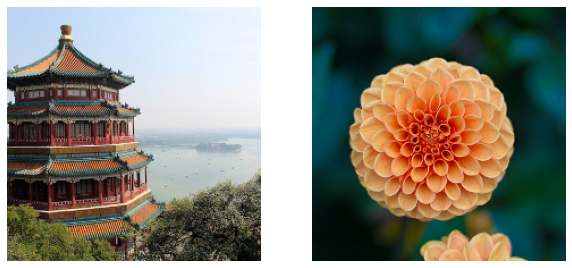

In [39]:
# Displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# Classification and Localization

to predict a bounding box around the object, a
common approach is to predict the horizontal and vertical coordinates of the
object’s center, as well as its height and width. This means we have four
numbers to predict.

In [40]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [41]:
dataset_size

3670

In [42]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [43]:
n_classes

5

In [44]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [45]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

83683744/83683744 [==============================] - 1s 0us/step


In [48]:
# fits the model using random target bounding boxes (in real life
# you would need to create proper targets instead)
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 24s 636ms/step - loss: 0.8951 - dense_loss: 1.0498 - dense_1_loss: 0.2765 - dense_accuracy: 0.5844 - dense_1_accuracy: 0.2688
Epoch 2/2
10/10 [==============================] - 8s 636ms/step - loss: 0.3103 - dense_loss: 0.3443 - dense_1_loss: 0.1743 - dense_accuracy: 0.9031 - dense_1_accuracy: 0.2562


# How mAP Relates to Precision/Recall

In [49]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

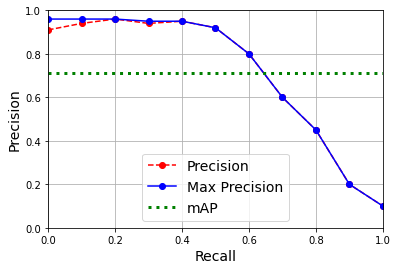

In [50]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

# Summary

1. These are the main advantages of a CNN over a fully connected DNN for image classification:
  - Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
  - When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
  - Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.

--------

2. Consider a CNN composed of three convolutional layers, each with 3
× 3 kernels, a stride of 2, and "same" padding. The lowest layer
outputs 100 feature maps, the middle one outputs 200, and the top one
outputs 400. The input images are RGB images of 200 × 300 pixels:
  - Number of parameters: $(3*3*(3)+1)*100 + (3*3*(100)+1)*200 + (3*3*200+1)*400$
  - Now let's compute how much RAM this neural network will require (at least) when making a prediction for a single instance. First let's compute the feature map size for each layer. Since we are using a stride of 2 and "same" padding, the horizontal and vertical dimensions of the feature maps are divided by 2 at each layer (rounding up if necessary). So, as the input channels are 200 × 300 pixels, the first layer's feature maps are 100 × 150, the second layer's feature maps are 50 × 75, and the third layer's feature maps are 25 × 38. Since 32 bits is 4 bytes and the first convolutional layer has 100 feature maps, this first layer takes up 4 × 100 × 150 × 100 = 6 million bytes (6 MB). The second layer takes up 4 × 50 × 75 × 200 = 3 million bytes (3 MB). Finally, the third layer takes up 4 × 25 × 38 × 400 = 1,520,000 bytes (about 1.5 MB). However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 3 = 9 million bytes (9 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer has not been released yet). But wait, you also need to add the memory occupied by the CNN's parameters! We computed earlier that it has 903,400 parameters, each using up 4 bytes, so this adds 3,613,600 bytes (about 3.6 MB). The total RAM required is therefore (at least) 12,613,600 bytes (about 12.6 MB).
  - Lastly, let's compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. During training TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the reverse pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50. At this point, let's start counting in megabytes rather than bytes. We computed before that the three layers require respectively 6, 3, and 1.5 MB for each instance. That's a total of 10.5 MB per instance, so for 50 instances the total RAM required is 525 MB. Add to that the RAM required by the input images, which is 50 × 4 × 200 × 300 × 3 = 36 million bytes (36 MB), plus the RAM required for the model parameters, which is about 3.6 MB (computed earlier), plus some RAM for the gradients (we will neglect this since it can be released gradually as backpropagation goes down the layers during the reverse pass). We are up to a total of roughly 525 + 36 + 3.6 = 564.6 MB, and that's really an optimistic bare minimum.

------------

3. If your GPU runs out of memory while training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM):
  - Reduce the mini-batch size.
  - Reduce dimensionality using a larger stride in one or more layers.
  - Remove one or more layers.
  - Use 16-bit floats instead of 32-bit floats.
  - Distribute the CNN across multiple devices.
----------

4. A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few
----------

5. A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level features that the upper layers can build upon.
-----------

6. The main innovations in AlexNet compared to LeNet-5 are that it is much larger and deeper, and it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The main innovation in GoogLeNet is the introduction of inception modules, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. ResNet's main innovation is the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative. SENet's main innovation was the idea of using an SE block (a two-layer dense network) after every inception module in an inception network or every residual unit in a ResNet to recalibrate the relative importance of feature maps. Xception's main innovation was the use of depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately. Lastly, EfficientNet's main innotation was the compound scaling method, to efficiently scale a model to a larger compute budget.
----------

7. Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height (at least above the minimum size). They are most useful for object detection and semantic segmentation because they only need to look at the image once (instead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some dense layers on top, you can convert these dense layers to convolutional layers to create an FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer's input size, with one filter per neuron in the dense layer, and using "valid" padding. Generally the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer's. The other dense layers should be converted the same way, but using 1 × 1 filters. It is actually possible to convert a trained CNN this way by appropriately reshaping the dense layers' weight matrices.
-----------

8. The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pixel.

---------

# High Accuracy CNN for MNIST

In [51]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

print(X_train.shape, X_valid.shape, X_test.shape)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(X_train.shape, X_valid.shape, X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)
(55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


In [53]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu',
                           kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu',
                           kernel_initializer='he_normal'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', 
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 8ms/step - loss: 0.2208 - accuracy: 0.9342 - val_loss: 0.0466 - val_accuracy: 0.9876
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0917 - accuracy: 0.9728 - val_loss: 0.0411 - val_accuracy: 0.9898
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.0653 - accuracy: 0.9796 - val_loss: 0.0318 - val_accuracy: 0.9912
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0527 - accuracy: 0.9835 - val_loss: 0.0379 - val_accuracy: 0.9902
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0333 - val_accuracy: 0.9906
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.0386 - val_accuracy: 0.9904
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 0.0360 - val_ac

In [54]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0306 - accuracy: 0.9918


[0.030634429305791855, 0.9918000102043152]